## Warning
Not the definitive version

In [2]:
%matplotlib inline

import numpy as np
import sys
from scipy import special, stats
from scipy.optimize import minimize, fminbound
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pickle

import mpstyle
mpstyle.mpSetParamStyle("code")
matplotlib.rcParams['figure.figsize'] = (20,10)
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['legend.handlelength'] = 2
matplotlib.rcParams['lines.linewidth'] = 3

<div class="alert alert-danger">

<b>Ce notebook est à remplir au fur et à mesure du cours et constituera votre rapport sur les trois premières journées de cours. Les questions entourées du symbole $\star$ sont à traiter en dehors du cours.</b></div>

<h1 class="text-center">EISC-211 : Méthodes de Monte-Carlo</h1>

<a id="IS"></a><h1 style="border: 5px solid; text-align: center; padding: 10px">IV. Méthodes de réduction de variance</h1>


<div class="alert alert-success"> 

Pour améliorer l'estimation de $I = \int \phi f$, l'idée des méthodes de réduction de variance (aussi appelées échantillonnage préférentiel) est d'utiliser une représentation différente de l'intégrale :
$$ I = \int \phi f = \int \widetilde{\phi} g \ \text{ avec } \widetilde \phi = \frac{\phi f}{g} $$
puis d'utiliser l'estimateur IIDMC
$$ \frac{1}{N} \sum_{k=1}^N \widetilde \phi(Y_k) $$
où les $Y_k$ sont i.i.d. de densité $g$. Vous verrez dans le DM3 que cette méthode a des liens profonds avec la méthode du rejet.</div>

<h2> IV.1. Exemple de la loi de Cauchy </h2>

On cherche dans cette partie à estimer la probabilité $p=P(X>2)$ où $X$ suit une loi de Cauchy, i.e., $X$ est une variable aléatoire absolument continue de densité
$$ f(x) = \frac{1}{\pi (1+x^2)}, \ x \in \mathbb{R}. $$
Pour cela, on va considérer $4$ estimateurs de Monte-Carlo:
$$ \widehat p^i_N = \frac{1}{N} \sum_{k=1}^N Y^i_k $$
où pour chaque $i=1,\dots,4$ les $(Y^i_k, k \in \mathbb{N})$ sont i.i.d.. Ces 4 estimateurs correspondent aux différentes écritures suivantes de $p$ :
$$\begin{align*}
p  & = \int {\bf 1}(x > 2)  f(x) d x & (1)\\
& = \frac{1}{2} \int  {\bf 1}(\lvert x \rvert > 2) f(x) d x & (2)\\
& = \frac{1}{2} - \int  f(x){\bf 1}(0 \leq x \leq 2) d x & (3)\\
& = \int_0^{1/2} \frac{y^{-2}}{\pi (1 + y^{-2})} d y & (4)
\end{align*}$$
(1) vient de la définition de $p$, (2) de la parité de $f$, (3) du fait que $f$ s'intègre à $1$ et est paire, et (4) vient de (1) et du changement de variable $y = 1/x$.

<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.1.1.</b> Justifiez que le meilleur estimateur soit celui qui corresponde à la variable aléatoire $Y^i_1$ de variance minimale.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.1.1.</b> </div>

Si ces estimateurs sont tous **sans biais** donc le meilleur sera celui qui assure une **variance minimale**

Montrons donc que ces estimateurs sont sans biais. Pour cela on montre que l'estimation de $p$ est de la forme $\displaystyle \int \phi_i f$, ainsi c'est une estimateur de i.i.d de Monte Carlo, et donc comme vu dans la partie II, il est sans biais.

On écrira les estimations $\displaystyle p_i = \int \phi_i f$. Donc on explicitera les fonctions $\phi_i$.

Pour $p_1$, on a directement $\boxed{\phi_1 = \textbf{1}(x>2)}$<br>
Pour $p_2$, on a, en rentrant $\frac{1}{2}$ dans l'intégrale $\displaystyle \boxed{\phi_2 = \frac{1}{2} \cdot \textbf{1}(|x|>2)}$<br>
Pour $p_3$, on écrit $\frac{1}{2}$ comme $\displaystyle \int \frac{f}{2}$, alors $\boxed{\phi_3 = \frac{1}{2} - \textbf{1}(0 \leq x \leq 2)}$<br>
Pour $p_4$, on remarque que $\displaystyle \frac{y^{-2}}{\pi(1+ y^{-2})} = \frac{1}{\pi(1+ y^2)} = f(y)$<br><br>
D'où $\displaystyle p_4 = \int \textbf{1} \left(0< x < \frac{1}{2} \right) f(x) \text{d}x$, $\boxed{\phi_4 = \textbf{1}(0<x<0.5)}$

<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.1.2.</b> $\widehat p^1$ correspond à l'estimateur naïf de Monte-Carlo : écrivez $Y^1_1 = \varphi_1(X)$ et estimez numériquement $\text{Var}(Y^1_1)$ dans ce cas.</p>

In [3]:
f = lambda x : 1/(np.pi * (1 + x**2))

N = 10**3
x = np.random.standard_cauchy(N)
y = x > 2
est = np.sum(y)/N
variance = est*(1-est)/N
print("Estimation:",est)
print("Variance de l'estimateur:",variance)
print(f"Variance np.var(y)/N = {np.var(y)/N}")

Estimation: 0.137
Variance de l'estimateur: 0.000118231
Variance np.var(y)/N = 0.00011823099999999999


<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.1.2.</b> </div>

<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.1.3.</b> Utilisez la représentation (2) pour construire $Y^2_1 = \varphi_2(\lvert X \rvert)$. Estimez numériquement $\text{Var}(Y^2_1)$ dans ce cas et justifiez théoriquement la réduction de variance.</p>

In [4]:
x = np.random.standard_cauchy(N)
y = (np.abs(x)>2)/2
est = np.sum(y)/N
variance = est*(1-2*est)/(2*N)
print("Estimation:",est)
print("Variance de l'estimateur:",variance)
print(f"Variance np.var(y)/N = {np.var(y)/N}")

Estimation: 0.16
Variance de l'estimateur: 5.4399999999999994e-05
Variance np.var(y)/N = 5.439999999999999e-05


<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.1.3.</b> </div>

<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.1.4.</b> Utilisez la représentation (3) pour construire $Y^3_1 = \varphi_3(U)$ où $U$ est uniformément répartie, et estimez numériquement $\text{Var}(Y^3_1)$ dans ce cas.</p>

In [5]:
u = np.random.random_sample(N) * 2
y = (0.5 - 2 * f(u))
est = np.sum(y)/N
esp1 = np.arctan(2)/(2*np.pi)
esp2 = (np.arctan(2) + 2/5)/(4*np.pi**2)
variance = 4*(esp2 - esp1**2)/N
print("Estimation:",est)
print("Variance de l'estimateur:",variance)
print(f"Variance np.var(y)/N = {np.var(y)/N}")

Estimation: 0.15132678692051593
Variance de l'estimateur: 2.850878546357294e-05
Variance np.var(y)/N = 2.7369915541055676e-05


<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.1.4.</b> </div>

<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.1.5.</b> Utilisez la représentation (4) pour construire $Y^4_1 = \varphi_4(U)$ où $U$ est uniformément répartie, et estimez numériquement $\text{Var}(Y^4_1)$ dans ce cas.</p>

In [6]:
u = np.random.random_sample(N) * 0.5
y = f(u)/2
est = np.sum(y)/N
esp1 = 2*np.arctan(1/2)/np.pi
esp2 = (np.arctan(1/2) + 2/5)/(np.pi**2)
variance = (esp2 - esp1**2)/(4*N)
print("Estimation:",est)
print("Variance de l'estimateur:",variance)
print(f"Variance np.var(y)/N = {np.var(y)/N}")

Estimation: 0.14702637800576324
Variance de l'estimateur: 9.55252996698748e-08
Variance np.var(y)/N = 9.429930195466733e-08


<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.1.5.</b> </div>

<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.1.6.</b> En reprenant les codes ci-dessus, calculez pour chacun de ces 4 estimateurs la taille de l'échantillon minimale qui permet d'estimer $p$ avec une erreur relative inférieure à $10^{-2}$ et commentez les résultats obtenus.</p>

In [7]:
err = 1e-2

N_ech = [0]*4
N = 10**5
for i in range(4) :
    match i :
        case 0 :         
            x = np.random.standard_cauchy(N) 
            y = x > 2
        case 1 :
            x = np.random.standard_cauchy(N)
            y = (np.abs(x)>2)/2
        case 2 :
            u = np.random.random_sample(N) * 2
            y = (0.5 - 2 * f(u))
        case 3 :
            u = np.random.random_sample(N) * 0.5
            y = f(u)/2
    est = np.average(y)
    #Var * N
    var_N = np.var(y)
    N_ech[i] = var_N/(est**2 * err**2)

print(f"Pour une erreur de {err:.1e}")
for i in range(0,4) :
    print(f"  Avec le {i+1}e estimateur, il faut un échantillon de taille {int(np.ceil(N_ech[i])):d}")

Pour une erreur de 1.0e-02
  Avec le 1e estimateur, il faut un échantillon de taille 57481
  Avec le 2e estimateur, il faut un échantillon de taille 23732
  Avec le 3e estimateur, il faut un échantillon de taille 12952
  Avec le 4e estimateur, il faut un échantillon de taille 44


<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.1.6.</b> </div>

<h2> IV.2. Echantillonnage préférentiel </h2>


Soit $g$ une densité de probabilité, appelée, comme pour le rejet, **densité auxiliaire** dans le cadre de l'échantillonnage préférentiel, telle que $g(x) = 0 \Rightarrow f(x) = 0$ si bien que le rapport $f(x) / g(x)$, et donc l'intégrale
$$ \int \phi \frac{f}{g} g, $$
sont bien définis si l'on adopte la convention $0/x = 0$ pour tout $x \in \mathbb{R}$. Soit $(Y_k, k \in \mathbb{N})$ des variables i.i.d. de densité $g$ et
$$ \widehat I^g_N = \frac{1}{N} \sum_{k=1}^N \phi(Y_k) \frac{f(Y_k)}{g(Y_k)} $$


<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.2.1.</b> Montrez que $\widehat I^g_N$ est un estimateur sans biais et convergent de $I$.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.2.1.</b> </div>

Parce que Monte Carlo

---

<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.2.2.</b> On suppose que $\phi \geq 0$ et l'on considère $g_{\text{opt}} = \phi f / I$. Montrez que $g_{\text{opt}}$ est une densité de probabilité lorsque $\phi \geq 0$, et montrez sans calcul que $\widehat I^{g_{\text{opt}}}_N$ est de variance nulle.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.2.2.</b> </div>

Trivial, laissé au lecteur

---

<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.2.3.</b> Que vaut $g_{\text{opt}}$ dans le cas de la sphère ? Peut-on l'utiliser ?</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.2.3.</b> </div>

C'est dla merde, fin c'est trop bien, mais ça dépend de $I$

---

<div class="alert alert-success"> 

Le problème de $g_{\text{opt}}$ est qu'elle dépend de la quantité $I$ que l'on cherche à estimer : <b>elle n'est donc pas utilisable en pratique mais cela suggère de chercher une densité auxiliaire qui lui soit proche.</b> En pratique, on se donne une famille paramétrique $\{g_\theta, \theta \in \Theta\}$ et on va chercher la "meilleure" fonction $g$ au sein de cette famille.</div>

Pour illustrer cette démarche, on reprend le problème d'estimation du volume de la sphère en dimension $30$. A la fin du BE précédent, nous avons en effet vu que l'estimateur naïf de Monte-Carlo n'était pas efficace dans ce cas. Pour cela, on considère la famille paramétrique $\{g_\theta, \theta > 0\}$ sur $\mathbb{R}^d$ où
$$ g_\theta(x) = \prod_{k=1}^d h_\theta(x_k) \ \text{ avec } \ h_\theta(x_1) \propto (1-x_1^2)^{\theta-1} {\bf 1}(x_1 \in [-1,1]), \ x = (x_1, \ldots, x_d) \in \mathbb{R}^d. $$

On notera $\widehat V^{\text{IS}(\theta)}_d$ l'estimation de $V_d$ obtenue par échantillonnage préférentiel en utilisant $g_\theta$ comme fonction auxiliaire.



<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.2.4.</b> Utilisez le script suivant pour tracer en dimension $d = 2$ la surface $g_\theta$ pour différentes valeurs de $\theta$, et expliquez intuitivement pourquoi, en grande dimension, il devrait être plus efficace de générer selon $g_\theta$ que selon $f$ lorsque $\theta > 1$.</p>

In [8]:
def g(x:np.array, theta:float) -> np.array :
    '''
    x est une matrice avec N lignes et d colonnes
    d est la dimension de l'espace
    N est la taille de l'echantillon
    La fonction renvoie un vecteur de longueur N où la k-ème entrée correspond à la fonction g
    appliquée à la k-ème ligne.
    '''
    dimension = x.shape[1]
    #taille_echantillon = x.shape[0]
    c =(2 * special.gamma(2*theta) )/ (4**np.float64(theta) * special.gamma(theta)**2)
    return c**dimension * np.power(np.prod(1 - np.power(np.float64(x), 2), 1), (np.float64(theta) - 1))

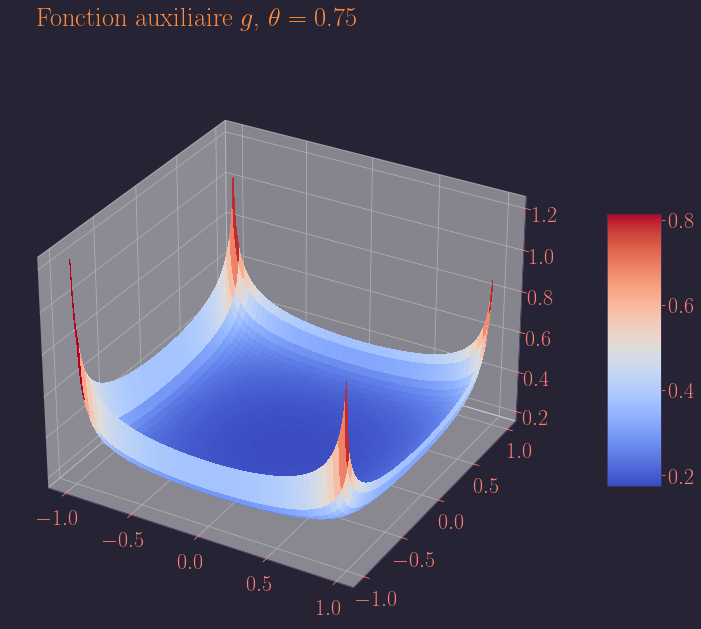

In [60]:
theta = .75
x = np.arange(-.99,.99,.01)
y = np.arange(-.99,.99,.01)
X, Y = np.meshgrid(x, y, indexing='ij')
Z = np.zeros(X.shape)
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j] = g(np.array([[x[i], y[j]]]), theta)
fig= plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.suptitle(fr"Fonction auxiliaire $g$, $\theta=$ {theta}")
plt.show()

<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.2.4.</b> </div>

On voit que la surface est proche de $0$ sur la plupart des valeurs, et est étirée au niveau des coins. 

---

On admet par la suite que si les $Y_k$ sont i.i.d. et suivent une loi beta de paramètre $(\theta, \theta)$, alors $g_\theta$ est la densité de $(2Y_k-1, k = 1,\ldots, d)$. Ainsi, pour générer une variable aléatoire de densité $g_\theta$, il suffit de savoir générer des variables aléatoires suivant la loi beta, ce que fait la fonction ``np.random.beta``.

<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.2.5.</b> Complétez le script suivant puis utilisez-le pour tracer la performance (estimation, écart relatif et erreur relative) de l'estimateur par échantillonnage préférentiel pour $N = 10^5$, $d \in [2,20]$ et $\theta = 7,5$. Comparez avec IIDMC. Que pensez-vous des résultats obtenus ? Analysez notamment l'influence du paramètre $\theta$.</p>

In [97]:
V_sph = lambda d : np.pi **(d/2)/ (special.gamma(d/2 + 1 ))

def estimation_IS(dim: int, N_ech: int, theta: float) -> list[float]:
    V_d = V_sph(dim)
    ech = np.random.beta(theta, theta, size=[N_ech, dim])
    y = (np.linalg.norm(2 * ech - 1, axis=1) <= 1)/(N_ech * g(2 * ech - 1,theta))
    est = np.sum(y) # *g
    ecart_relatif = np.abs(est-V_d)/V_d 
    erreur_relative = np.sqrt(np.var(y)/N_ech)/np.average(y)
    return [est, ecart_relatif, erreur_relative]


Estimation par échantillonnage préférentiel en dimension : 

20 : [====================================] 100.00%

Text(0.5, 0.98, 'Erreur relative')

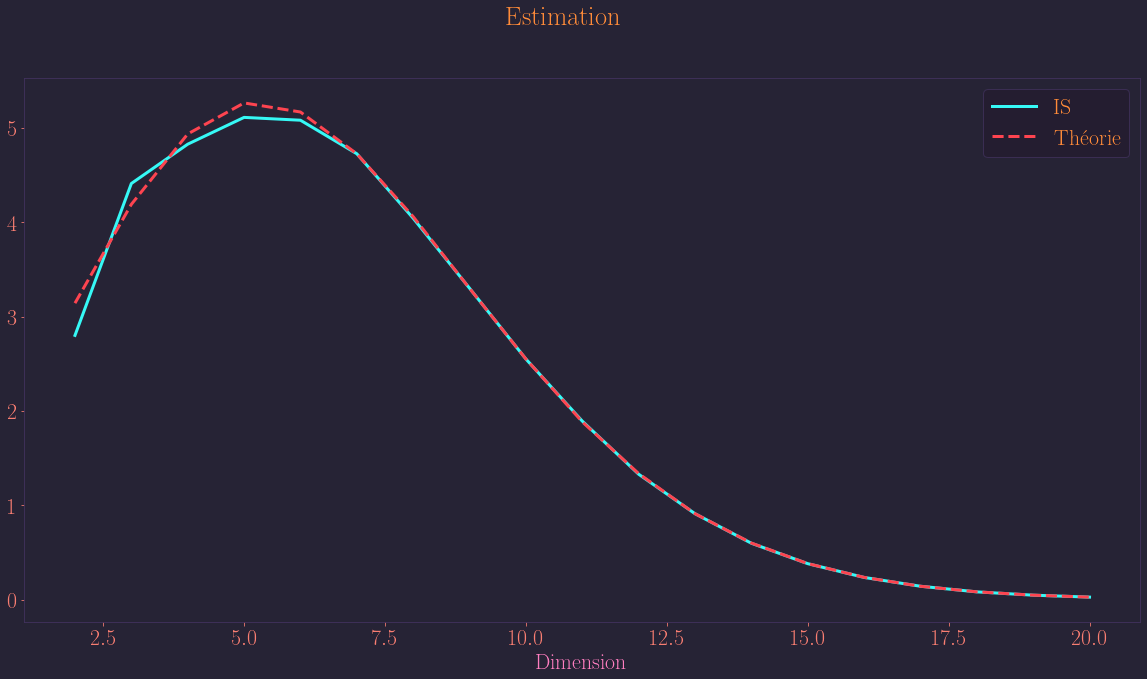

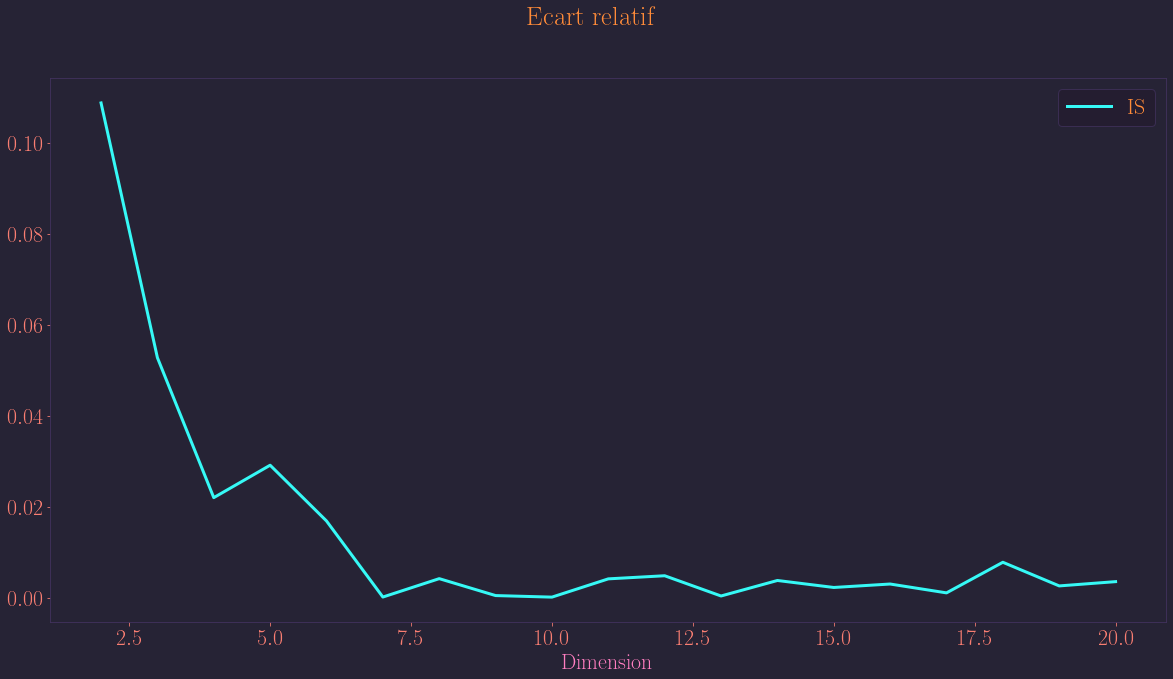

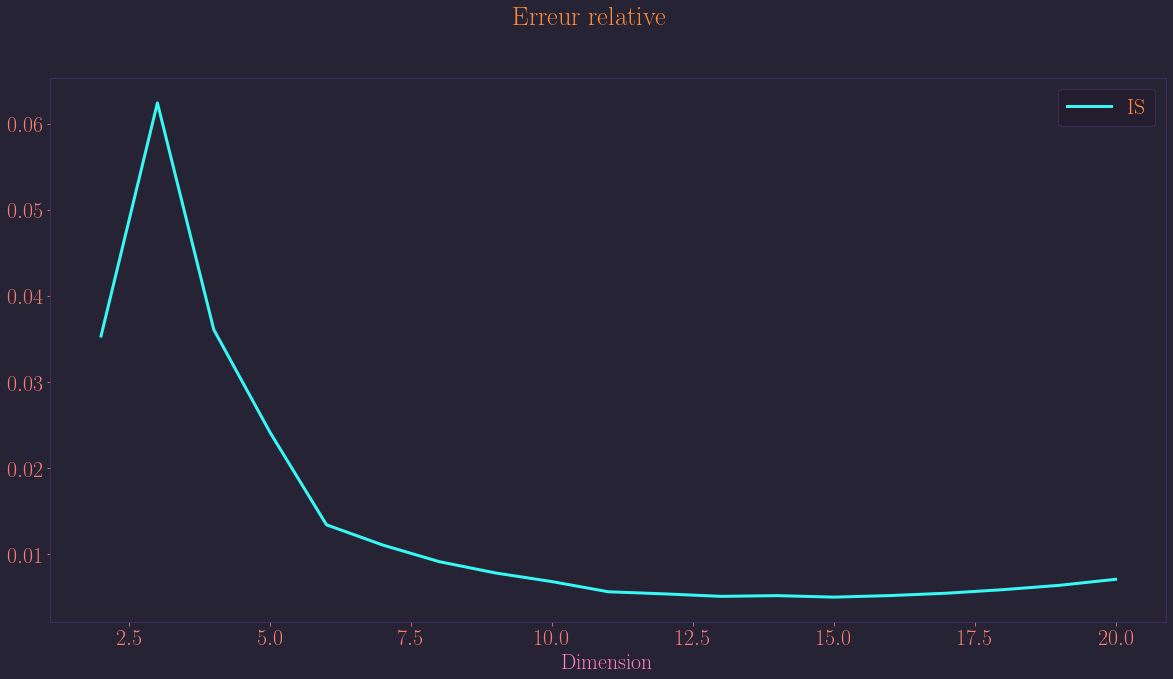

In [96]:
# Calculs des valeurs
N = 10**5
dimensions = range(2,21)
est_IS = np.zeros([len(dimensions),3])
theta = 7.5
val_th = np.zeros([len(dimensions),1])
print("Estimation par échantillonnage préférentiel en dimension : \n")
for i in range(len(dimensions)):
    #TODO
    d = dimensions[i]
    #print("\033[AMy text overwriting the previous line.")
    print(f"\r{d} : [" + "=" * (d-2)*2 + " "* (20-d)*2 + f"] {100*(d-2)/18:.2f}%",end="")
    est_IS[i,:] = estimation_IS(dimensions[i],N,theta) 
    val_th[i] = np.pi**(dimensions[i]/2) / special.gamma(dimensions[i]/2+1)

# Affichage
fig = plt.figure()
plt.plot(dimensions, est_IS[:,0], label="IS")
plt.plot(dimensions, val_th, '--', label="Théorie")
plt.legend()
plt.xlabel("Dimension")
fig.suptitle("Estimation")

fig = plt.figure()
plt.plot(dimensions, est_IS[:,1], label="IS")
plt.legend()
plt.xlabel("Dimension")
fig.suptitle("Ecart relatif")

fig = plt.figure()
plt.plot(dimensions, est_IS[:,2], label="IS")
plt.legend()
plt.xlabel("Dimension")
fig.suptitle("Erreur relative")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.2.5.</b> </div>

<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.2.6.</b> On cherche maintenant à comprendre l'influence de $\theta$. On fixe $N = 10^5$ et $d = 30$: tracez l'évolution de $\widehat V^{\text{IS}(\theta)}_d$, de l'écart relatif et de l'erreur relative correspondant pour $\theta \in [1,30]$ et discutez les résultats.</p>

29 : [================================================] 100.00%

Text(0.5, 0.98, 'Erreur relative')

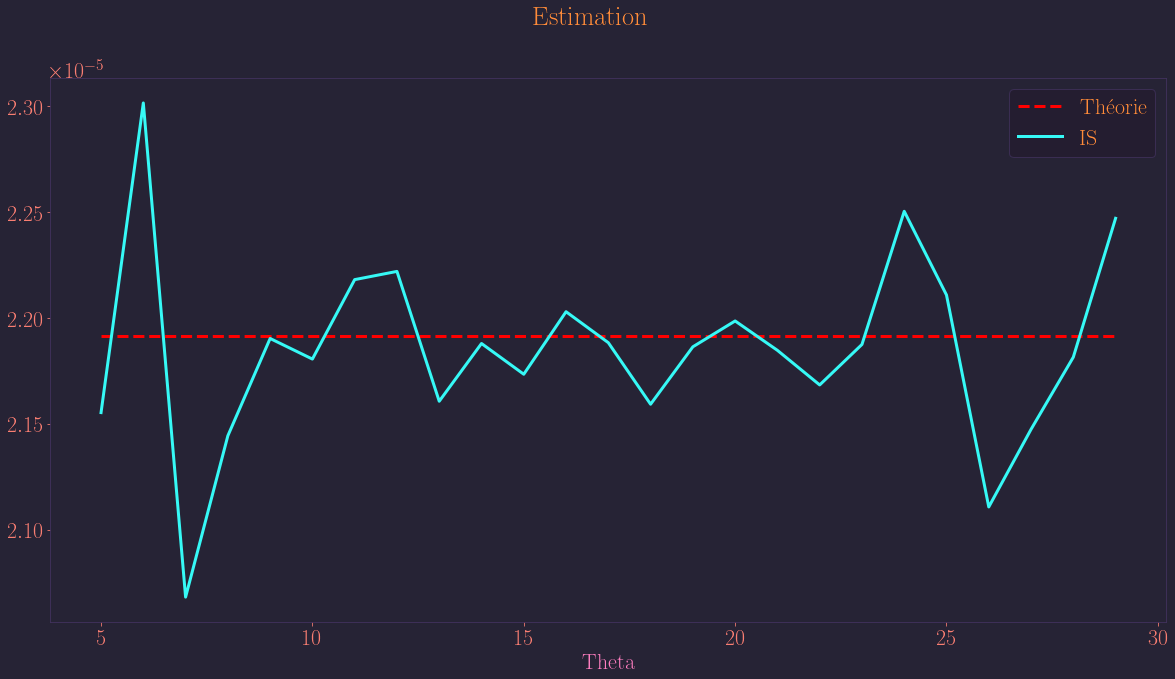

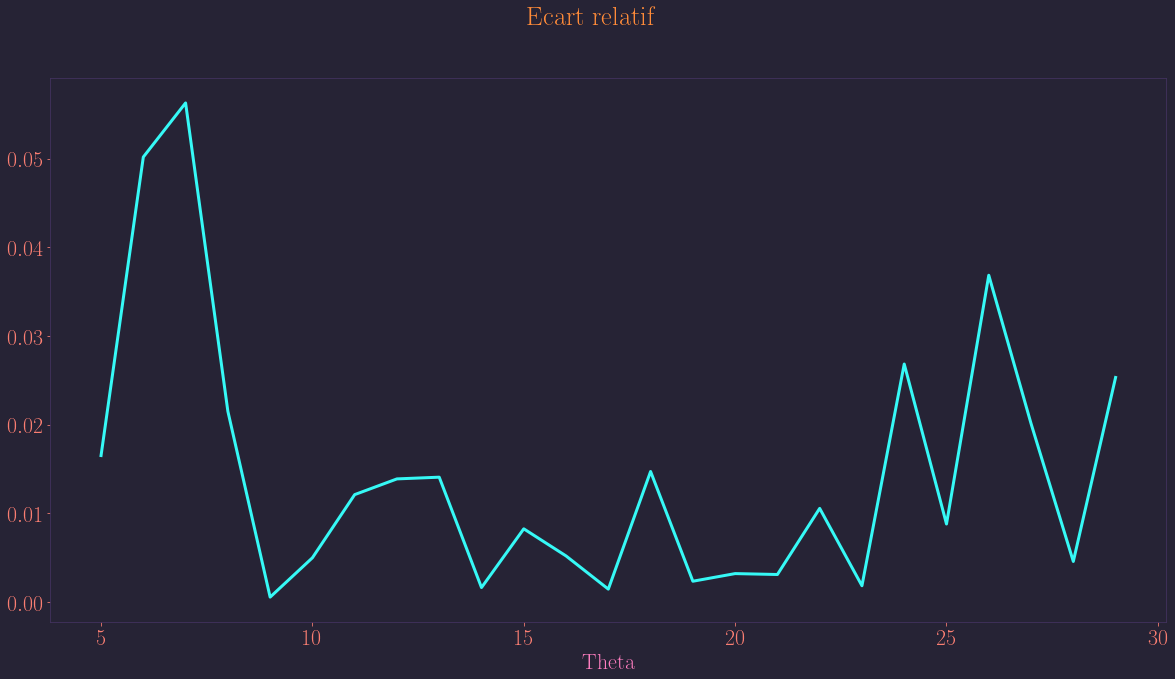

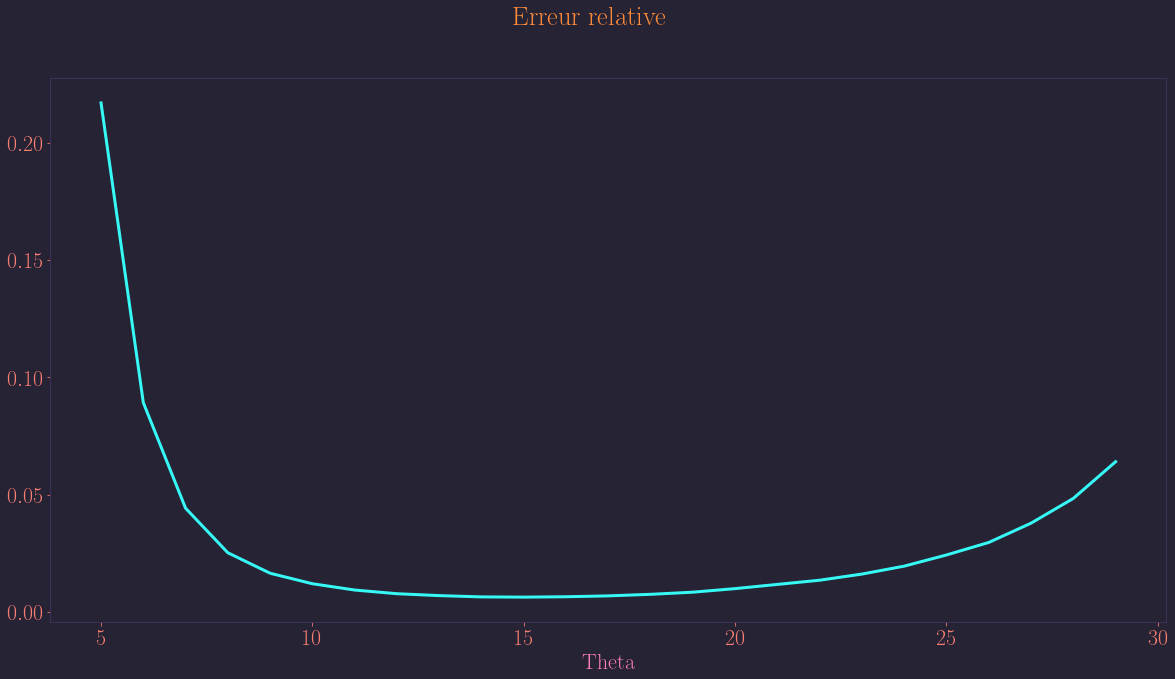

In [103]:
# Calculs des valeurs
N = 10**5
d = 30
theta = np.arange(5,30,1)
est_IS = np.zeros([len(theta),3])
for (i,t_) in enumerate(theta):
    print(f"\r{t_} : [" + "=" * (t_-5)*2 + " "* (29-t_)*2 + f"] {100*(t_-5)/(29-5):.2f}%",end="")
    est_IS[i,:] = estimation_IS(d,N,t_)

# Affichage
fig = plt.figure()
th = np.zeros([len(theta),1]) + np.pi**(d/2) / special.gamma(d/2+1)
plt.plot(theta, th, 'r--', label="Théorie")
plt.plot(theta, est_IS[:,0], label="IS")
plt.legend()
plt.xlabel("Theta")
fig.suptitle("Estimation")

fig = plt.figure()
plt.plot(theta, est_IS[:,1])
plt.xlabel("Theta")
fig.suptitle("Ecart relatif")

fig = plt.figure()
plt.plot(theta, est_IS[:,2])
plt.xlabel("Theta")
fig.suptitle("Erreur relative")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.2.6.</b> </div>

<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.2.7.</b> Pour $N = 10^5$ et $d = 30$, déterminez numériquement le paramètre $\theta_{\text{opt}}$ qui minimise l'erreur relative de $\widehat V_d^{\text{IS}(\theta)}$. Estimez l'erreur relative de $\widehat V_d^{\text{IS}(\theta_{\text{opt}})}$ et estimez le budget de simulation nécessaire pour déterminer $\theta_{\text{opt}}$. Evaluez le nombre d'échantillons nécessaires pour obtenir la même erreur relative que $\widehat V_d^{\text{IS}(\theta_{\text{opt}})}$ par IIDMC. Enfin, étudiez également l'influence de $N$ sur la procédure d'optimisation. </p>

In [112]:
def optim_var_IS(theta):
    vol_estim = estimation_IS(30, 10**5, theta)
    return vol_estim[2]
from termcolor import colored

print(colored('hello', 'red'), colored('world', 'green'))

hello world


In [114]:
N = 10**5
d=30
x0 = 5
res_optim = minimize(optim_var_IS, x0, method='nelder-mead',options={'xtol': 1e-5, 'disp': True})
N_tot_IS = res_optim.nit*N
vol_estim = estimation_IS(30, 10**5, res_optim.x)
print(f"Volume estimé par échantillonnage préférentiel optimisé : {vol_estim[0]:.3e}")
print(f"avec un theta optimisé de {res_optim.x[0]:.2f}, erreur relative de {res_optim.fun:.2e} pour un budget de simulations de {N_tot_IS+10**5:,d}")
th =np.pi**(d/2) / special.gamma(d/2+1)
taille_MC = 0 # TODO
print("Nombre d'échantillons Monte-Carlo nécessaires pour obtenir une précision équivalente à IS:",taille_MC)

Optimization terminated successfully.
         Current function value: 0.006206
         Iterations: 26
         Function evaluations: 64
Volume estimé par échantillonnage préférentiel optimisé : 2.211e-05
avec un theta optimisé de 14.76, erreur relative de 6.21e-03 pour un budget de simulations de 2,700,000
Nombre d'échantillons Monte-Carlo nécessaires pour obtenir une précision équivalente à IS: 0


<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.2.7.</b> </div>

<h2> IV.3. Echantillonnage préférentiel adaptatif par minimisation de l'entropie croisée</h2>

L'erreur relative de $\widehat V_d^{\text{IS}(\theta)}$ n'est en général pas une fonction convexe de $\theta$.  L'approche naïve de recherche du paramètre $\theta$ proposée en IV.2.7 ne converge plus et même des algorithmes d'optimisation plus performants ne sont pas toujours adaptés, notamment lorsque le nombre d'échantillons disponible est limité. La technique de minimisation de l'entropie croisée est une approche pour résoudre ces problèmes.

La divergence de Kullback-Leibler, aussi appelée entropie relative, caractérise la dissimilarité entre deux distributions de probabilités. Si $g$ est absolument continue par rapport à $f$, i.e., $g(x) = 0 \Rightarrow f(x) = 0$, alors l'entropie relative entre $f$ et $g$ est donnée par
$$ {\cal D}(f,g)=\int f \log(f/g) = \int f(x) \log\left( \frac{f(x)}{g(x)}\right) d x. $$
L'entropie relative satisfait les deux propriétés suivantes :
1. ${\cal D}(f,g)\geq 0$;
2. ${\cal D}(f,g)=0$ si et seulement si $f=g$ presque partout;

qui font que ${\cal D}(f,g)$ donne une notion de distance entre $f$ et $g$. Dans le contexte précédent d'échantillonnage préférentiel, la technique de minimisation de l'entropie croisée consiste à déterminer $\theta_{\text{optCE}}$ qui minimise ${\cal D}(g_{\text{opt}},g_\theta)$.

<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.3.1.</b> Montrez que
$$ \arg \min_\theta {\cal D}(g_{\text{opt}}, g_\theta) = \arg \max_\theta \int f \phi \log g_\theta $$
et déduisez-en que, bien que $g_{\text{opt}}$ ne soit pas calculable, le problème d'optimisation l'est.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.3.1.</b> </div>

On veut minimiser $\mathcal{D}(g_{\text{opt}},g_{\theta})$, on va donc le réexprimer :
$$\begin{align*} 
\mathcal{D}(g_{\text{opt}},g_{\theta}) &=\int g_{\text{opt}} \log \left( \frac{g_{\text{opt}}}{g_{\theta}} \right)\\
&= \int \frac{f \phi}{I} \log \left( \frac{f \phi}{g_\theta I} \right) \\
&= \frac{1}{I} \left( \underbrace{\int f \phi \log \left( \frac{f \phi}{I} \right)}_{\text{constant en }\theta} - \int f \phi \log g_\theta \right)
\end{align*}$$

$\mathcal{D}(g_{\text{opt}},g_{\theta})$ est décroissante avec $\displaystyle \int f \phi \log g_\theta$

Ainsi, minimiser $\mathcal{D}(g_{\text{opt}},g_{\theta})$ revient à maximiser $\displaystyle \int f \phi \log g_\theta$.


---

<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.3.2.</b> Proposez une estimation de la fonction objectif du problème d'optimisation précédent par méthode de Monte-Carlo. Que vaut numériquement l'estimation par IIDMC de cette espérance dans le cas de l'estimation du volume d'une sphère en dimension 30?</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.3.2.</b> </div>

<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.3.3.</b> Cette espérance est donc estimée par échantillonnage préférentiel en pratique. La fonction <code>estimation_IS_entropie_croisee</code> propose une implémentation de l'algorithme d'échantillonnage préférentiel adaptatif par minimisation de l'entropie croisée pour l'estimation du volume d'une sphère de dimension $30$. Analysez les différentes étapes de cette fonction. Que vaut $\phi$ au cours de l'algorithme? Pourquoi faire varier $\phi$? Quel est l'influence attendue du paramètre $\rho$? 
Tracer l'évolution de l'estimation du volume et de son erreur relative obtenue par entropie croisée en fonction de la dimension.</p>

In [ ]:
def estimation_IS_entropie_croisee(dimension, taille_echantillon, rho):
    vol_th = np.pi**(dimension/2) / special.gamma(dimension/2+1)
    theta0=1   
    echantillon = 2 * np.random.beta(a=theta0,b=theta0,size=(taille_echantillon, dimension))-1
    x=g(echantillon, theta0)
    x.astype('float_')
    estimation = np.mean(np.multiply(np.linalg.norm(echantillon, 2, axis=1) < 1, np.reciprocal(x)))
    dist=np.linalg.norm(echantillon, 2, axis=1)
    S = np.percentile(dist,(1-rho)*100)
    newtheta = theta0;
    
    while(S>1):
        fmin = lambda theta: --np.sum(np.multiply(np.multiply(np.linalg.norm(echantillon, 2, axis=1) < S, np.reciprocal(x)),np.log(g(echantillon, theta))))
        newtheta=fminbound(fmin,1,30)
        echantillon = 2 * np.random.beta(a=newtheta,b=newtheta,size=(taille_echantillon, dimension))-1
        x=g(echantillon, newtheta)
        dist=np.linalg.norm(echantillon, 2, axis=1)
        S = np.percentile(dist,(1-rho)*100)

    estimation = np.mean(np.multiply(np.linalg.norm(echantillon, 2, axis=1) < 1, np.reciprocal(x)))    
    ecart_relatif = (estimation - vol_th) / vol_th
    ecart_type = np.sqrt(np.var(np.multiply(np.linalg.norm(echantillon, 2, axis=1) < 1, np.reciprocal(x)))/taille_echantillon)
    erreur_relative=  ecart_type / estimation
    return [estimation, ecart_relatif, erreur_relative]

In [ ]:
est_IS =estimation_IS_entropie_croisee(30, 10**4,0.8)
print(est_IS)

<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.3.3.</b> </div>

<p class="bg-primary" style="padding:1em">

<b>QUESTION IV.3.4.</b> Déterminer numériquement le paramètre $\theta_{\text{optCE}}$ qui minimise ${\cal D}(g_{\text{optCE}},g_\theta)$. Estimez l'erreur relative de $\widehat V_d^{\text{IS}(\theta_{\text{optCE}})}$ et évaluez le budget de simulation nécessaire pour déterminer $\theta_{\text{optCE}}$. Evaluez le nombre d'échantillons IIDMC nécessaires pour obtenir la même erreur relative qu'avec  $\widehat V_d^{\text{IS}(\theta_{\text{optCE}})}$.</p>

In [ ]:
def estimation_IS_entropie_croisee_bud(dimension, taille_echantillon, rho):
    ###fonction équivalente à estimation_IS_entropie_croisee, elle renvoie en plus le nombre d'échantillons générées dans l'algorithme
    
    vol_th = np.pi**(dimension/2) / special.gamma(dimension/2+1)
    theta0=1   
    echantillon = 2 * np.random.beta(a=theta0,b=theta0,size=(taille_echantillon, dimension))-1
    budget=taille_echantillon
    x=g(echantillon, theta0)
    x.astype('float_')
    estimation = np.mean(np.multiply(np.linalg.norm(echantillon, 2, axis=1) < 1, np.reciprocal(x)))
    dist=np.linalg.norm(echantillon, 2, axis=1)
    S = np.percentile(dist,(1-rho)*100)
    newtheta = theta0;
    
    while(S>1):
        fmin = lambda theta: --np.sum(np.multiply(np.multiply(np.linalg.norm(echantillon, 2, axis=1) < S, np.reciprocal(x)),np.log(g(echantillon, theta))))
        newtheta=fminbound(fmin,1,30)
        echantillon = 2 * np.random.beta(a=newtheta,b=newtheta,size=(taille_echantillon, dimension))-1
        budget=budget+taille_echantillon
        x=g(echantillon, newtheta)
        dist=np.linalg.norm(echantillon, 2, axis=1)
        S = np.percentile(dist,(1-rho)*100)

    estimation = np.mean(np.multiply(np.linalg.norm(echantillon, 2, axis=1) < 1, np.reciprocal(x)))    
    ecart_relatif = (estimation - vol_th) / vol_th
    ecart_type = np.sqrt(np.var(np.multiply(np.linalg.norm(echantillon, 2, axis=1) < 1, np.reciprocal(x)))/taille_echantillon)
    erreur_relative=  ecart_type / estimation
    return [estimation, ecart_relatif, erreur_relative, budget, newtheta]

In [ ]:
N = 10**4
d=30
est_IS =estimation_IS_entropie_croisee_bud(30, 10**4,0.8)
N_tot_IS=est_IS[3]
print("Volume estimé par importance sampling optimisé par CE:",est_IS[0])
print("avec un theta optimisé de",est_IS[4],"erreur relative de ",est_IS[2]," pour un budget de simulations de",est_IS[3])

th =np.pi**(d/2) / special.gamma(d/2+1)
taille_MC=1/est_IS[2]**2 / th*2**d
print("Nombre d\'échantillons Monte-Carlo nécessaires pour obtenir une précision équivalente à IS:",taille_MC)

<div class="alert alert-warning"><b>REPONSE A LA QUESTION IV.3.4.</b> </div>